In [1]:
# For importing from the parent directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Standard imports
import matplotlib.pyplot as plt
%matplotlib inline
from utils import data as dt
from time import perf_counter

# PyTorch
import torch
import torch.nn.functional as F
from MLP_torch import MLP_torch

# MLX
import mlx
import mlx.core as mx
import mlx.optimizers as optim
from MLP_mlx import MLP_mlx

# For reproducibility
torch.manual_seed(0)
mx.random.seed(0)

# Data

In [2]:
# PyTorch
device = 'cpu'
x_pt, y_pt = dt.noisy_sin_torch(n=200, device=device)

# MLX
x_mlx, y_mlx = dt.noisy_sin_mlx(n=200)

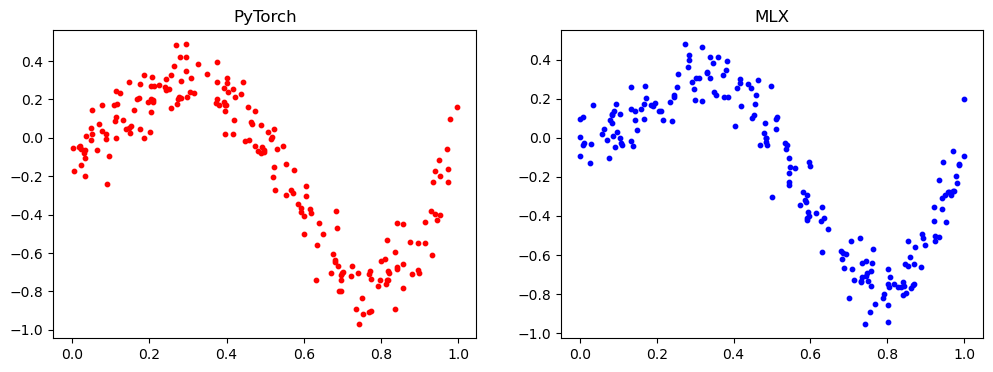

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(x_pt.cpu().numpy(), y_pt.cpu().numpy(), c='r', s=10)
ax[0].set_title('PyTorch')
ax[1].scatter(x_mlx, y_mlx, c='b', s=10)
ax[1].set_title('MLX')
plt.show()

# Train

In [4]:
# PyTorch
def train_torch(x, y, model, params):
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    loss_fn = torch.nn.MSELoss()
    
    for _ in range(params['iters']):
        optimizer.zero_grad()      # Zero the gradients
        output = model(x)          # Forward pass
        loss = loss_fn(output, y)  # Compute the loss
        loss.backward()            # Backward pass
        optimizer.step()           # Update the weights
    
    return model


# MLX
def train_mlx(x, y, model, params):
    optimizer = optim.Adam(learning_rate=params['lr'])
    def loss_fn(model, X, y): return mlx.nn.losses.mse_loss(model(X), y)
    loss_and_grad_fn = mlx.nn.value_and_grad(model, loss_fn)
    
    for _ in range(params['iters']):
        loss, grads = loss_and_grad_fn(model, x, y)  # Forward, loss, and backward pass
        optimizer.update(model, grads)               # Update the weights
    
    return model

In [5]:
params = {
    'iters': 1000,
    'lr' : 0.05,
}

model_torch = MLP_torch().to(device)
model_mlx = MLP_mlx()

# Pytorch
start = perf_counter()
model_torch = train_torch(x_pt, y_pt, model_torch, params)
end = perf_counter()
print(f'PyTorch training time: {end - start:.2f} seconds')

# MLX
start = perf_counter()
model_mlx = train_mlx(x_mlx, y_mlx, model_mlx, params)
end = perf_counter()
print(f'MLX training time: {end - start:.2f} seconds', '\n')

# Forward pass
start = perf_counter()
y_pred_pt = model_torch(x_pt).cpu().detach().numpy()
end = perf_counter()
print(f'PyTorch forward pass time: {end - start:.4f} seconds')

start = perf_counter()
y_pred_mlx = model_mlx(x_mlx)
end = perf_counter()
print(f'MLX forward pass time: {end - start:.4f} seconds')

PyTorch training time: 0.16 seconds
MLX training time: 0.24 seconds 

PyTorch forward pass time: 0.0004 seconds
MLX forward pass time: 0.0000 seconds


# Result

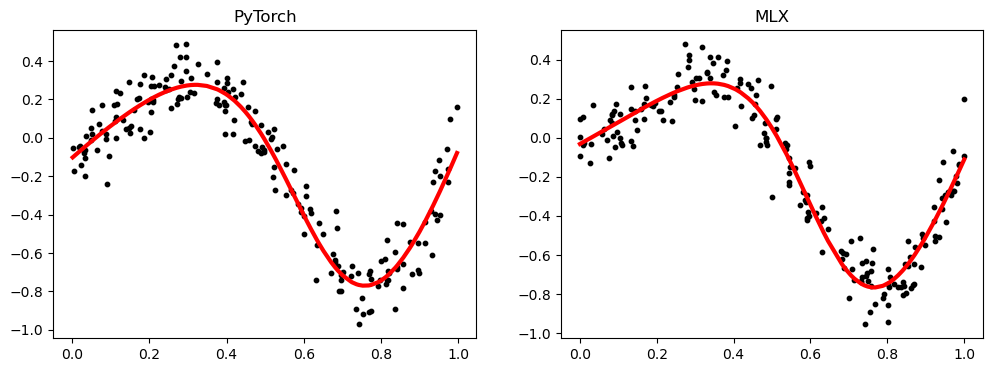

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(x_pt.cpu().numpy(), y_pt.cpu().numpy(), c='black', s=10)
ax[0].plot(x_pt.cpu().numpy(), y_pred_pt, c='r', lw=3)
ax[0].set_title('PyTorch')
ax[1].scatter(x_mlx, y_mlx, c='black', s=10)
ax[1].plot(x_mlx, y_pred_mlx, c='r', lw=3)
ax[1].set_title('MLX')
plt.show()